In [19]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.abspath("../")) 

import cv2
import numpy as np
from IPython.display import Image, display


def showFrame(frame):
    ok, buf = cv2.imencode('.png', frame)
    if not ok:
        raise RuntimeError("Could not encode frame to PNG")
    display(Image(data=buf.tobytes()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Calibration

Find three points in both the visual and thermal space, and build an Affine
transformation matrix so we can convert thermal back to image.  This will
allow us to paint the thermal impact patch back into the visual.


### Questions

* Does calibration just automatically happen, or do we need a special mode?
* Do we look for some number of frames and average the locations??



Final calibration matrix at frame 66:
[[ 1.38724782e+00  2.01100450e-02 -7.83809764e+01]
 [ 3.28716025e-02  1.40602086e+00 -6.26867910e+01]]


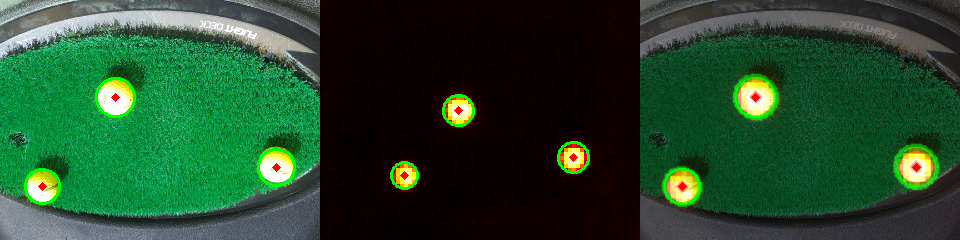

Final calibration matrix at frame 177:
[[  1.26507395   0.13971573 -74.82696708]
 [  0.08782738   1.28035898 -57.71437919]]


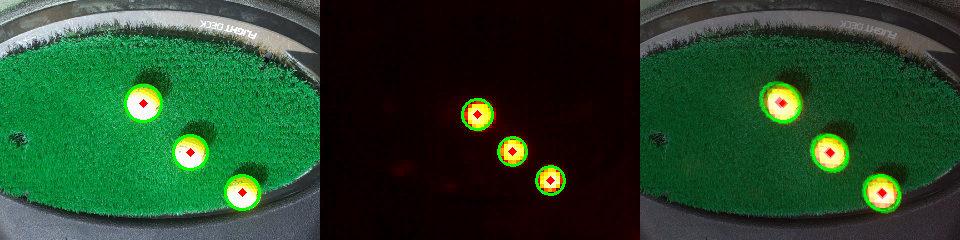

In [31]:
from strikepoint.frames import FrameInfoReader
from strikepoint.circles import findBrightestCircles, drawBrightestCircles

with FrameInfoReader("data/demo-three-balls.bin") as reader:
    frameInfoList = list(enumerate(reader.readAllFrameInfo()))
    calibCount, calibMatrixList, lastCalibFrame = 8, list(), 99999

    for i, frameInfo in frameInfoList:
        visFrame = frameInfo.rgbFrames['visual']
        thermFrame = frameInfo.rgbFrames['thermal']

        try:
            visCircles = findBrightestCircles(visFrame, 3)
            thermCircles = findBrightestCircles(thermFrame, 3)
            visMatrix = np.float32([c[:2] for c in sorted(visCircles[:3])])
            thermMatrix = np.float32([c[:2] for c in sorted(thermCircles[:3])])
            M = cv2.getAffineTransform(thermMatrix, visMatrix)

            if i != lastCalibFrame+1:
                calibMatrixList.clear()
            lastCalibFrame = i
            calibMatrixList.append(M)
            if len(calibMatrixList) == calibCount:
                M = sum(calibMatrixList) / len(calibMatrixList)
                print(f"Final calibration matrix at frame {i}:\n{M}")
                visDemo = drawBrightestCircles(
                    visFrame, visCircles, targetCount=3)
                thermDemo = drawBrightestCircles(
                    thermFrame, thermCircles, targetCount=3)
                Hv, Wv = visDemo.shape[:2]
                thermWarped = cv2.warpAffine(
                    thermDemo, M, (Wv, Hv), flags=cv2.INTER_LINEAR,
                    borderMode=cv2.BORDER_CONSTANT, borderValue=0)
                final = cv2.addWeighted(visDemo, 0.5, thermWarped, 0.5, 0)    
                showFrame(np.hstack((visDemo, thermDemo, final)))
                calibMatrixList.clear()

        except RuntimeError:
            continue